## CNN Based Denoiser and Simulation of Noise Models
### Tutorial
---
In this tutorial I will explain every line of code that is written. Following this tutorial will give a thorough and basic introduction to PyTorch, Noise models, Denoising and other image processing concepts.

### Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np # doesn't need an explanation. It's just there to work with arrays since python doesn't have arrays
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from skimage.util import random_noise

#### PyTorch
PyTorch is a python library developed by Meta. It is used for machine learning using Tensors.

---

`Torch.optim.Optimizer(params, defaults)` - you can create an object which will optimize a model's parameters based on the algorithm chosen. To do this,

`optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)` - this initializes the object `optimizer` which uses SGD (Stochastic Gradient Descent) to optimize `model`'s parameters with a learning rate of 0.01 and momentum of 0.9. You can call other methods like `optim.Adam` to perform Adaptive momentum gradient descent.

*`params`* - it has to be a tensor iterable

---

`Torch.nn` - a fundamental module for all ML related tasks. It creates neural networks, graphs, convolutional layers, pooling layers, loss functions, etc.,

---

`torchvision` - is a package of the PyTorch framework that has all the popular functions, architectures related to computer vision.

`torchvision.transforms` - is a class in the `torchvision` package that deals with image transformations such as resizing, cropping, rotation, flipping, etc.,

---

`torch.utils.data` - is a really important package as it deals with loading datasets, easy batching of the dataset, sampling, and other important functions.

`DataLoader` - a very simple way to deal with datasets. PyTorch allows for map-style and iterable-style datasets. Map-style is like a dictionary, with keys and values. Iterable-style datasets have a user defined iterable.

```python
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, *, prefetch_factor=2,
           persistent_workers=False)`
```




### Classes and Functions Definitions

In [40]:
class NoisyDataset(Dataset):
  '''
  This class is like an extension to torch.utils.data. We use it to add noise to the image and return the image and noisy image as tensors.
  We can also specify the type of noise to add. Currently I have implemented Gaussian, Poisson, and Salt and Pepper noise.
  '''
  def __init__(self,  dataset, noise_type = 'gaussian', noise_level = 0.1):
    print("Initializing object...\n")
    self.dataset = dataset
    self.noise_type = noise_type
    self.noise_level = noise_level

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    image, _ = self.dataset[idx] # ignoring labels
    image_np = image.numpy().squeeze() # make sure its a numpy array
    #image = np.array(image) / 255.0 # converting to numpy array and normalizing to [0, 1] so it works better on neural networks

    if self.noise_type == 'gaussian':
      noisy_image_np = random_noise(image, mode='gaussian', var=self.noise_level**2)
    elif self.noise_type == 'poisson':
      noisy_image_np = random_noise(image, mode='poisson')
    elif self.noise_type == 'salt_and_pepper':
      noisy_image_np = random_noise(image, mode='s&p', amount=self.noise_level)
    else:
      raise ValueError("Unsupported Noise Type")

    noisy_image = torch.from_numpy(noisy_image_np).float().unsqueeze(0)
    return noisy_image, image

#### Explanation
This is a class `NoisyDataset`. It has 3 methods inside it.

---

The first method is a constructor. It is called everytime an object of this class is initialized. It stores the dataset, noise type and noise level within ech object.

---

The second method simply returns the length (number of images in this case) of the dataset. For example, if the user runs,

```python
print(len(noisy_dataset))
```

Then this method is called.

---

The third method takes the image at given index and adds the specified type of noise to it and returns both original image and noise added image as tensors. It will be called if the user runs,

```python
print(noisy_dataset[0])
```

---

#### Skimage

Skimage is an image processing library for python. We use random_noise method from this library. It works for floating point images.

In [42]:
class DenoisingAutoEncoder(nn.Module): # we have nn.Module as the argument because this class inherits from torch.nn.Module
  '''
  This class is a CNN based denoiser. It has an encoder and a decoder. The explanation is given below in the markdown textbox.
  The commented code can be used if training a deeper network than the current one. Changes to the code would include changing the input and output channels of the convolutional layers.
  And not forgetting the commas.
  '''
  def __init__(self):
    super(DenoisingAutoEncoder, self).__init__() # calls the constructor for proper intialization
    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Add pooling to reduce size
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # Ensure the input is the correct shape
    if len(x.shape) == 5:
        x = x.squeeze(1)

    # Encode
    x = self.encoder(x)

    # Decode
    x = self.decoder(x)

    return x

#### **Explanation**

This is a class `DenoisingAutoEncoder`. It has 2 methods inside it.

---

The first method is a constructor again as is usual for classes. it has two attributes, `encoder` and `decoder`. The encoder is used to compress the image to a latent space and the decoder does the inverse to give back the image in its original form. Both of these are made up of 2D convolutional layers and activation functions. The goal is to learn how to remove noise from the input images by training with noisy images and their corresponding cleaner versions.

---

The second method tells us the flow of the entire process. First we pass the input through the encoder and then we pass it through the decoder and return it.

---

#### **CNNs**

There is a reason why we have the number of layers in `encoder` and `decoder` that we do. Too few layers will not have the capacity to extract all meaningful features for proper reconstruction while too many layers will lead to overfitting because the neural network will start learning noise patterns in the training dataset.

---

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1)
```
https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md This link has nice animations for each of these parameters.

---

**How MaxPool2D works**

Input feature map:
$$
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{bmatrix}
$$

With **MaxPool2d(kernel_size=2, stride=2)**:

Resulting feature map:
$$
\begin{bmatrix}
6 & 8 \\
14 & 16
\end{bmatrix}
$$

Basically downsamples the input to only capture the most importance information. `ConvTranspose2d` does its exact opposite by doing 'learned' upsampling of the input so it can go back to its original form after MaxPool downsamples it.

---


#### **ReLU and Sigmoid**

We can not randomly use these activation functions in the layers. ReLU is used in between the layers to extract stronger features and get rid of the **vanishing gradient** problem. While Sigmoid is used at the end to give the output between 0 and 1, which is good for grayscale images. Using Sigmoid everywhhere else will result in **saturated neurons**.

---

**Vanishing gradient** problems refers to when in very deep networks, during backpropagation, the gradients become way too small to cause a meaningful difference. As a result of this, the earlier layers in the network stop learning. ReLU helps with this because it does not squash the values between 0 and 1 like tanh or Sigmoid.

---

**Saturated neurons** occur when they reach the extreme values of their activation functions (0 and 1 for Sigmoid, -1 and 1 for tanh). When neurons saturate, their gradient becomes very small and the network stops learning. ReLU does not saturate so it is used in between layers.

In [26]:
def show_images(image,noisy,denoised):
  # using matplotlib to write a simple function that will show us the three images side by side
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  axes[0].imshow(image, cmap='gray')
  axes[0].set_title('Original')
  axes[1].imshow(noisy, cmap='gray')
  axes[1].set_title('Noisy')
  axes[2].imshow(denoised, cmap='gray')
  axes[2].set_title('Denoised')
  plt.show()

In [44]:
def train_denoiser(model, dataloader, epochs = 10, lr = 0.001):
  '''
  This function trains the Autoencoder. It takes the model, dataloader, number of epochs and learning rate as arguments.
  It returns the trained model.
  '''
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  model.train()
  for epoch in range(epochs):
    total_loss = 0.0
    for noisy_imgs, clean_imgs in dataloader:
      # Ensure correct input shape
      if len(noisy_imgs.shape) == 5:
        noisy_imgs = noisy_imgs.squeeze(1)
      if len(clean_imgs.shape) == 3:
        clean_imgs = clean_imgs.unsqueeze(1)

      # Move to device
      noisy_imgs = noisy_imgs.to(device)
      clean_imgs = clean_imgs.to(device)

      # Zero gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(noisy_imgs)

      # Compute loss
      loss = criterion(outputs, clean_imgs)

      # Backward pass and optimize
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(dataloader):.4f}')
  return model

#### **Explanation**

Finally we train the Autoencoder to remove noise from the images using gradient descent. We can play around with the number of epochs and learning rate to see if the output improves. We can also use different optimizers to see what works best.

---

**MSE** - We are using mean squared error as the loss criterion which is good enough for 2d grayscale images.

---

`zero_grad` - clears the gradients from the previous epoch

---



### Training

Loading Dataset...
Adding Noise to Dataset...
Initializing object...

Making batches...
Starting training...
Epoch 1/10, Average Loss: 0.0186
Epoch 2/10, Average Loss: 0.0055
Epoch 3/10, Average Loss: 0.0049
Epoch 4/10, Average Loss: 0.0047
Epoch 5/10, Average Loss: 0.0045
Epoch 6/10, Average Loss: 0.0044
Epoch 7/10, Average Loss: 0.0043
Epoch 8/10, Average Loss: 0.0042
Epoch 9/10, Average Loss: 0.0041
Epoch 10/10, Average Loss: 0.0041


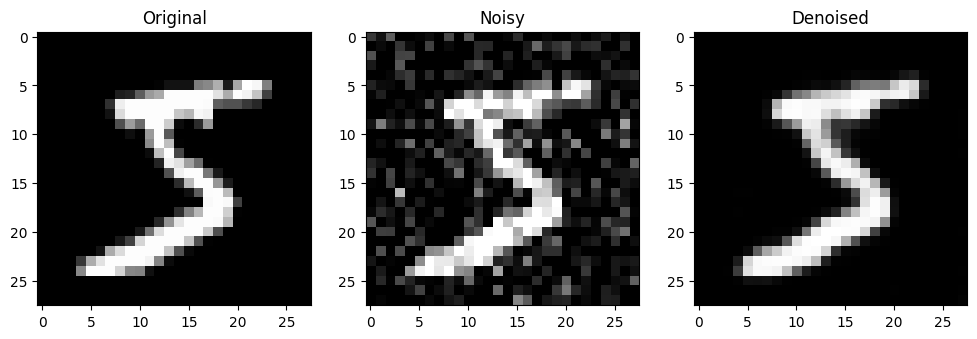

In [45]:
if __name__ == '__main__':
    # Load dataset
    print("Loading Dataset...")
    mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

    # Add noise
    print("Adding Noise to Dataset...")
    noisy_dataset = NoisyDataset(mnist_dataset, noise_type='gaussian', noise_level=0.2)

    # Use shuffle and select 64 images per batch
    print("Making batches...")
    dataloader = DataLoader(noisy_dataset, batch_size=64, shuffle=True)

    # Initialize the model and train
    print("Starting training...")
    denoiser = DenoisingAutoEncoder()
    trained_denoiser = train_denoiser(denoiser, dataloader)

    # Test on sample images
    sample_noisy, sample_original = noisy_dataset[0]
    sample_noisy = sample_noisy.unsqueeze(0)  # add batch dimension

    with torch.no_grad():
        sample_denoised = trained_denoiser(sample_noisy).squeeze().numpy()

    # Display output
    show_images(sample_original.squeeze().numpy(),
                sample_noisy.squeeze().numpy(),
                sample_denoised)

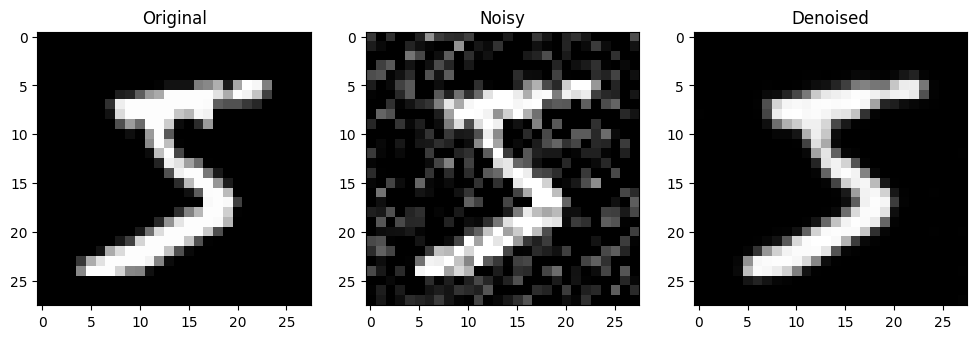

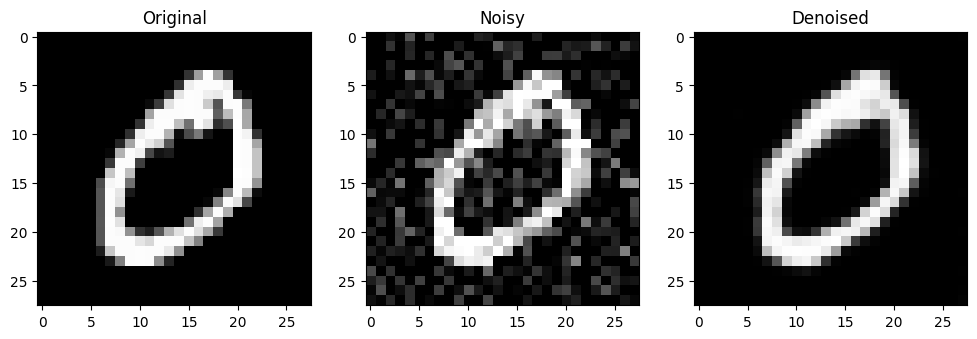

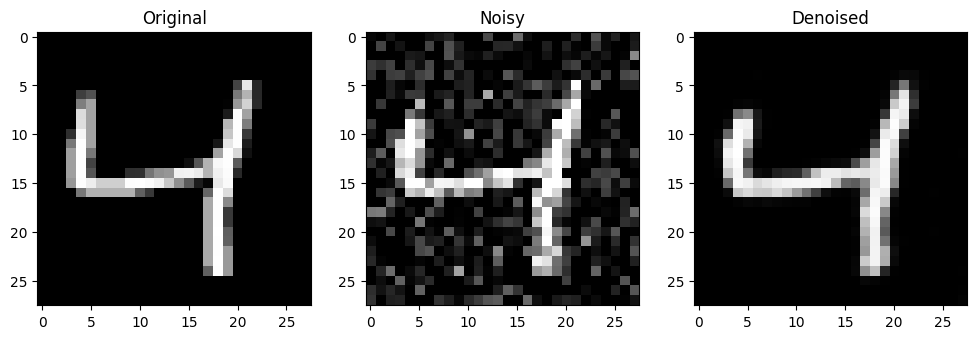

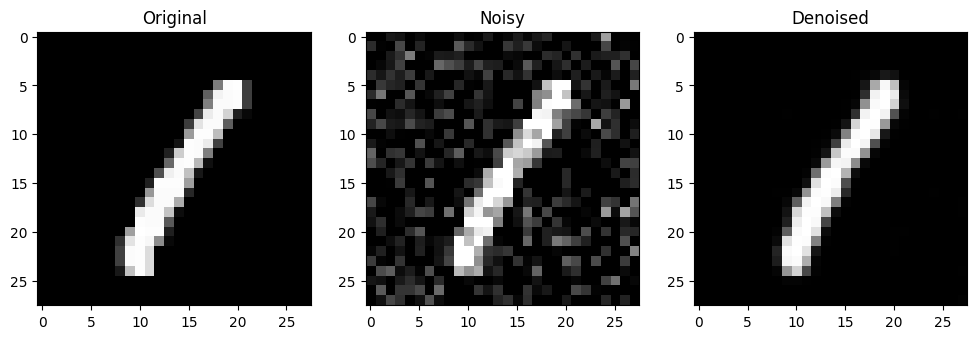

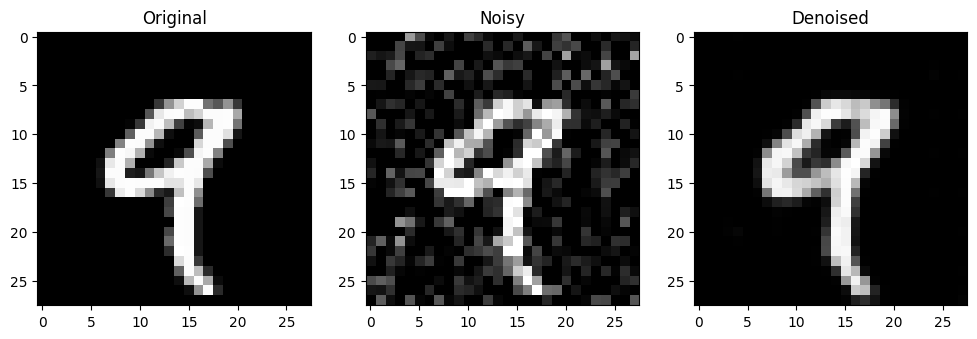

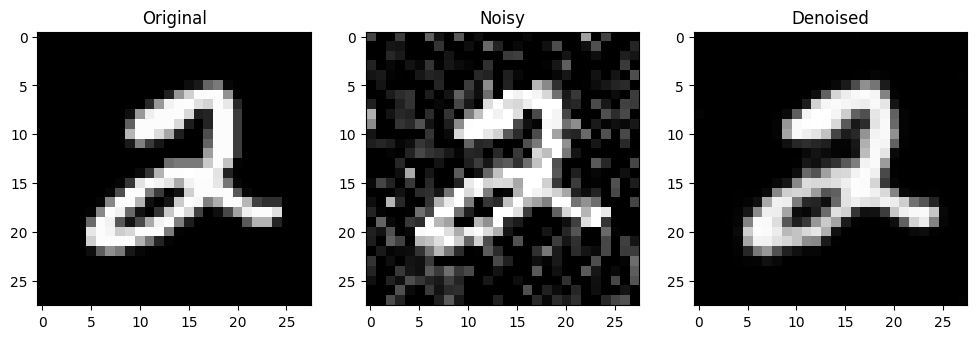

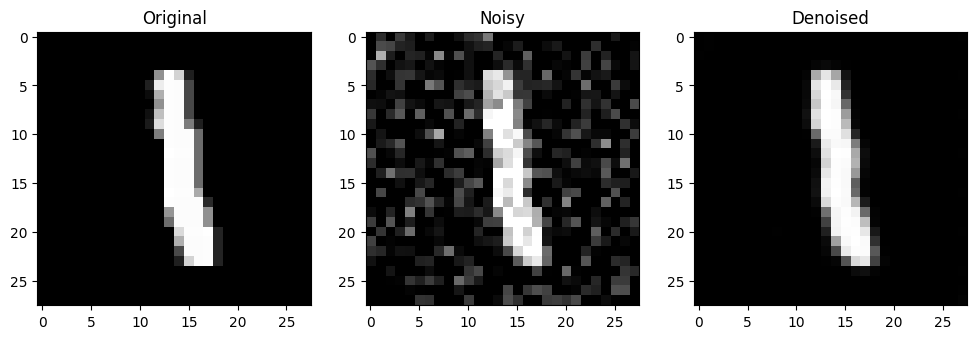

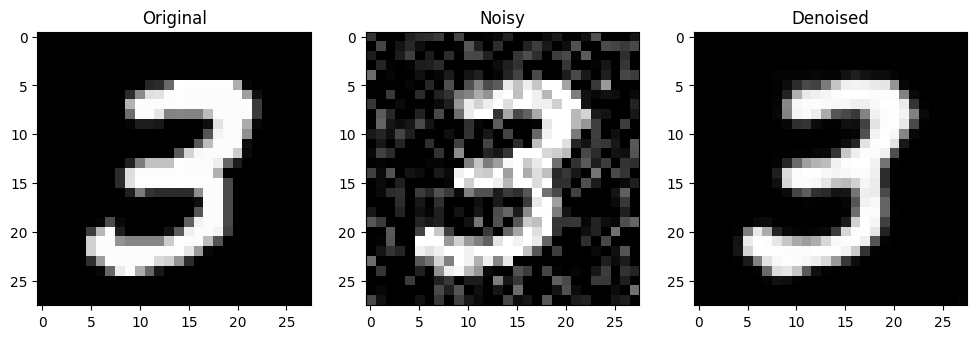

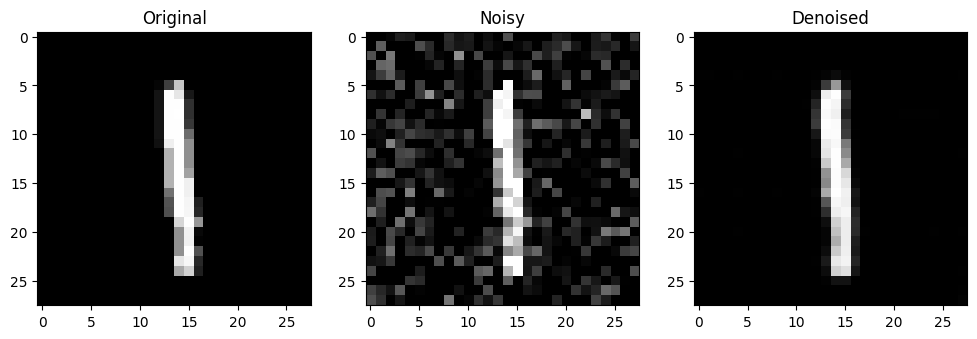

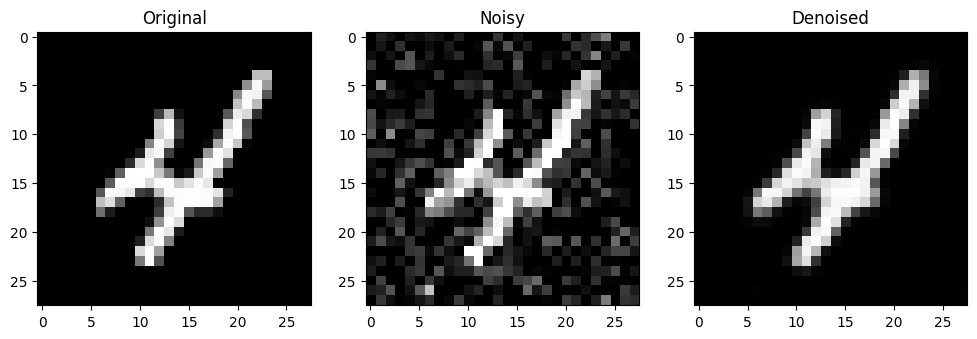

In [46]:
for i in range(10):
  sample_noisy, sample_original = noisy_dataset[i]
  sample_noisy = sample_noisy.unsqueeze(0)  # add batch dimension

  with torch.no_grad():
    sample_denoised = trained_denoiser(sample_noisy).squeeze().numpy()

  # Display output
  show_images(sample_original.squeeze().numpy(),
                sample_noisy.squeeze().numpy(),
                sample_denoised)